# SOLVING A VEHICLE-ROUTING PROBLEM (VRP) USING PARTICLE SWARM OPTIMIZATION (PSO) "Please Upload the csv file located in the same folder"

In [167]:
import itertools
import random
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import datetime
import statistics
import math
import matplotlib.colors as mcolors
import colorsys

# Creating the dataset

In [168]:
# n_customer = 1000
# n_point = n_customer + 1
# vehicle_capacity = 10


# df = pd.DataFrame({
#     'X': np.random.randint(0, 100, n_point),
#     'Y': np.random.randint(0, 100, n_point),
#     'Demand': np.random.randint(1, 6, n_point),
# })

# start_times = np.random.randint(low=1, high=10, size=n_point)
# end_times = np.random.randint(low=start_times+1, high=12, size=n_point)

# time_windows = np.column_stack((start_times, end_times))

# new_df = pd.DataFrame(time_windows, columns=['Start Time', 'End Time'])

# df = pd.concat([df, new_df], axis=1)

# df.loc[0, 'X'] = 0
# df.loc[0, 'Y'] = 0
# df.loc[0, 'Demand'] = 0
# df.loc[0, 'Start Time'] = 0
# df.loc[0, 'End Time'] = 0

# df

# Initialization

## 1. Reading csv file

In [169]:
num_customers = int(input("Enter the size of the problem (Number of customers): "))
num_trucks = int(input("Enter the number of trucks in your system: "))
capacity = int(input("Enter the capacity of your trucks (Assuming they're all identical): "))

# num_customers = int(input("Number of Customers: "))
# num_trucks = int(input("Number of Trucks: "))
# capacity = int(input("Capacity of trucks: "))

df = pd.read_csv('/content/VRP_dataset.csv')

df = df[:num_customers]

Enter the size of the problem (Number of customers): 100
Enter the number of trucks in your system: 20
Enter the capacity of your trucks (Assuming they're all identical): 20


In [170]:
def plot_init(df):
  plt.figure(figsize=(15, 15))

  for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['X'], row['Y'], c='r')
        plt.text(row['X'] + 1, row['Y'] + 1, 'depot')
    else:
        plt.scatter(row['X'], row['Y'], c='black')
        demand = row['Demand']
        plt.text(row['X'] + 1, row['Y'] + 1, f'{i}({demand})')
      
  plt.xlim([-10, 110])
  plt.ylim([-10, 110])
  plt.title('Points: Customer_ID(Demand)')
  plt.show()

In [171]:
# plot_init(df)

## 2. initializing truck destinations randomly

In [172]:
def initialize_population(num_trucks, num_customers):
    pop = np.zeros((num_trucks, num_customers), dtype=int)
    vel = np.zeros((num_trucks, num_customers), dtype=int)

    cities = np.arange(num_customers)
    np.random.shuffle(cities)
    truck_index = 0

    for city in cities:
        pop[truck_index, city] = 1
        truck_index = (truck_index + 1) % num_trucks

    # Initialize the velocity matrix with random values between -1 and 1
    vel = np.random.uniform(low=-1, high=1, size=num_trucks)

    return pop, vel

In [173]:
trucks = initialize_population(num_trucks, num_customers)
trucks

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 array([-0.89449058, -0.34938037,  0.44795627, -0.46054487, -0.46461468,
         0.50500923, -0.63546261,  0.63354671,  0.33273873,  0.83532888,
        -0.48745897, -0.00418011, -0.46471506, -0.25519892,  0.8041003 ,
        -0.89583784, -0.93632068,  0.61136603, -0.66897264,  0.69300227]))

## 3. Distance matrix

In [174]:
distances = pd.DataFrame(distance_matrix(df[['X', 'Y']].values, df[['X', 'Y']].values), index=df.index, columns=df.index).values

In [175]:
def plot_heatmap(distances):
  fig, ax = plt.subplots(figsize=(20, 20))
  sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
  plt.title('Distance Matrix')
  plt.show()

In [176]:
# plot_heatmap(distances)

# PSO

## TIME MATRIX

In [177]:
start = df["Start Time"]
end = df["End Time"]

time_matrix = np.zeros((num_customers, 2))

for i in range(num_customers):
  time_matrix[i] = [start[i], end[i]]

time_matrix

array([[ 0.,  0.],
       [ 4.,  8.],
       [ 9., 11.],
       [ 5., 11.],
       [ 2.,  6.],
       [ 2.,  9.],
       [ 9., 11.],
       [ 8.,  9.],
       [ 4.,  9.],
       [ 1.,  2.],
       [ 4.,  5.],
       [ 6.,  8.],
       [ 5., 11.],
       [ 3.,  4.],
       [ 3., 11.],
       [ 7., 10.],
       [ 6.,  8.],
       [ 1.,  3.],
       [ 1.,  5.],
       [ 9., 11.],
       [ 8., 10.],
       [ 7., 11.],
       [ 2.,  3.],
       [ 7.,  8.],
       [ 9., 11.],
       [ 8., 10.],
       [ 5.,  8.],
       [ 9., 11.],
       [ 7.,  8.],
       [ 8., 10.],
       [ 8., 10.],
       [ 4.,  6.],
       [ 8., 10.],
       [ 2.,  6.],
       [ 5.,  8.],
       [ 3., 10.],
       [ 4.,  5.],
       [ 1.,  7.],
       [ 8.,  9.],
       [ 4., 11.],
       [ 5.,  9.],
       [ 8., 11.],
       [ 6., 11.],
       [ 8., 10.],
       [ 9., 10.],
       [ 1.,  9.],
       [ 1.,  5.],
       [ 8., 11.],
       [ 5., 11.],
       [ 8.,  9.],
       [ 1.,  6.],
       [ 1.,  9.],
       [ 5.,

## CALCULATING FITNESS

In [178]:
def calculate_fitness(pos, distances, num_customers):
  customer_demands = df["Demand"]

  route_demand = 0
  total_distance = 0
  current_capacity = 0
  total_demand = 0

  sequence = []

  for i in range(num_customers):
    if pos[i] == 1:
      sequence.append(i)

  total_distance += distances[0][sequence[0]]
  current_time = 1
  s = len(sequence)-1

  for i in range(s):
    total_demand += customer_demands[sequence[i]]
    total_distance += distances[sequence[i]][sequence[i+1]]

    if total_demand > capacity:
      return -math.inf

    # if current_time > time_matrix[sequence[i]][1] or current_time < time_matrix[sequence[i]][0]:
    #   return -math.inf
    
    current_time += 1

    current_capacity += customer_demands[i]

  fitness = distances[0][sequence[0]]

  for i in range(s):
    fitness += distances[sequence[i]][sequence[i+1]]

  return fitness


## UPDATING BEST POPULATION

In [179]:
def compare(positions, p_i, pbest_fitness, p_g, gbest_fitness):
  fitness = 0
  for i in range(num_trucks):
    fitness += calculate_fitness(positions[i], distances, num_customers)
    
    if fitness > pbest_fitness[i]:
        p_i[i] = positions[i].copy()
        pbest_fitness[i] = fitness

  if fitness > gbest_fitness:
      p_g = positions.copy()
      gbest_fitness = fitness
    
  return p_i, pbest_fitness, p_g, gbest_fitness

## UPDATE POSITION AND VELOCITY

In [180]:
def updatevidXid(positions, v_i, p_i, pbest_fitness, p_g, gbest_fitness, c_cog, c_soc, w):
    #p_i --> particle best positions
    #p_g --> global best positions
    #positions --> x_i
    #pbest_fitness --> best fitness array for each truck 

    # Update the velocities of the particles
    r_cog = np.random.rand(num_trucks, num_customers)
    r_soc = np.random.rand(num_trucks, num_customers)

    cognitive = c_cog * r_cog * (p_i - positions)
    social = c_soc * r_soc * (p_g - positions)

    temp = w * v_i
    v_i = np.clip(temp + cognitive + social, -v_max, v_max)
    
    # Update the positions of the particles
    positions = np.clip(positions + v_i, 0, 1)

    
    positions, v_i = initialize_population(num_trucks, num_customers)
    # Evaluate the fitness of each particle and update the personal and global bests

    p_i, pbest_fitness, p_g, gbest_fitness = compare(positions, p_i, pbest_fitness, p_g, gbest_fitness)
    
    return positions, p_i, pbest_fitness, p_g, gbest_fitness, v_i

## trial

In [181]:
def updateVidXid(positions, v_i, p_i, pbest_fitness, p_g, gbest_fitness, c_cog, c_soc, w):
  positions, v_i = initialize_population(num_trucks, num_customers)
  p_i, pbest_fitness, p_g, gbest_fitness = compare(positions, p_i, pbest_fitness, p_g, gbest_fitness)
  
  return positions, p_i, pbest_fitness, p_g, gbest_fitness, v_i

## Plot

In [182]:
def plot_optimal(df, seq):
  # Define the customer locations
  customers_x = df["X"]
  customers_y = df["Y"]

  customers = np.column_stack((customers_x, customers_y))

  # Define the truck routes and colors
  routes = seq
  named_colors = list(mcolors.CSS4_COLORS.keys())

  # Remove the color "white" from the list
  named_colors.remove('white')

  # Get a list of 30 evenly spaced indices in the named_colors list
  indices = [int(i) for i in np.linspace(0, len(named_colors)-1, 30)]

  # Get the colors at the selected indices
  colors = ['#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50', 
             '#8E44AD', '#2980B9', '#16A085', '#F1C40F', '#E67E22', 
             '#27AE60', '#BDC3C7', '#2E4053', '#6D4C41', '#7B241C']

  # Plot the customer locations and truck routes
  fig, ax = plt.subplots(figsize=(20, 20))
  for i, (x, y) in enumerate(customers):
      ax.scatter(x, y, color='black')
      ax.annotate(str(i), (x+1, y+1))
  for i, r in enumerate(routes):
      x = [customers[i][0] for i in r]
      y = [customers[i][1] for i in r]
      x.append(customers[r[0]][0])
      y.append(customers[r[0]][1])
      color = colors[i % len(colors)]
      ax.plot(x, y, color=color)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Truck Routes')
  plt.show()

# MAIN PSO FUNCTION

In [183]:
def PSO(population, num_trucks, numItr,capacity, num_customers, v_max,c_cog,c_soc):

    #population --> trucks
    #numItr: number of iterations.(generations)
    #x_max: the upper limit for each decision variable (positions). [10,12]
    #x_min: the lower limit for each decision variable (positions). [1,2]
    #v_max: the upper limit for each decision variable (velocity). [2,4]
    #c_cog: cognitive constant (c1)
    #c_soc: social constant (c2)
    
    #Intialize

    final_pop = np.zeros((num_trucks, num_customers))

    positions = population[0]    #array that stores the list of positions of all particles
    velocities = population[1]   #array that stores the list of velocitites of all particles

    p_i = np.zeros((num_trucks, num_customers), dtype=int)
    p_g = np.zeros((num_trucks, num_customers), dtype=int)
    pbest_fitness = np.zeros(num_trucks)
    gbest_fitness = 0
    particle_bestFit = -1000
    global_bestFit = -1000
    w = 0.7

    p_i, pbest_fitness, p_g, gbest_fitness = compare(positions, p_i, pbest_fitness, p_g, gbest_fitness)

    #repeat till number of iterations
    for iterations in range(numItr):
      x_i = positions
      v_i = velocities

      #Update particle best position and global best position
      positions, p_i, pbest_fitness, p_g, gbest_fitness, velocities = updateVidXid(x_i,v_i,p_i,pbest_fitness,p_g,gbest_fitness,c_cog,c_soc,w)
      
    l = []
    for i in range(num_trucks):
      print(f"Truck ({i+1}) Route: ")
      seq = []
      for j in range(num_customers):
        if p_g[i][j] == 1:
          seq.append(j)
      if seq[0] == 0:
        l.append(seq)
        print(seq)
        print('\n')
      else:
        z = [0]
        t = z + seq
        l.append(t)
        print(t)
        print('\n')
      
    return gbest_fitness, l
    # p_g: the position with the best fitness in the final generation.

Number of Iterations: 100


Truck (1) Route: 
[0, 28, 54, 60, 61, 93]


Truck (2) Route: 
[0, 30, 48, 50, 53, 69]


Truck (3) Route: 
[0, 13, 70, 73, 86, 96]


Truck (4) Route: 
[0, 1, 2, 14, 20, 68]


Truck (5) Route: 
[0, 36, 43, 44, 71, 87]


Truck (6) Route: 
[0, 24, 40, 79, 91, 94]


Truck (7) Route: 
[0, 17, 49, 52, 82, 89]


Truck (8) Route: 
[0, 15, 32, 45, 80, 90]


Truck (9) Route: 
[0, 22, 47, 57, 72, 84]


Truck (10) Route: 
[0, 19, 25, 33, 76, 88]


Truck (11) Route: 
[0, 3, 9, 51, 67, 83]


Truck (12) Route: 
[0, 4, 6, 64, 65, 95]


Truck (13) Route: 
[0, 10, 56, 74, 85, 97]


Truck (14) Route: 
[0, 8, 12, 21, 41, 66]


Truck (15) Route: 
[0, 5, 23, 55, 59, 63]


Truck (16) Route: 
[0, 7, 16, 18, 38, 81]


Truck (17) Route: 
[0, 26, 34, 46, 77, 98]


Truck (18) Route: 
[0, 35, 37, 42, 58, 92]


Truck (19) Route: 
[0, 29, 31, 62, 75, 99]


Truck (20) Route: 
[0, 11, 27, 39, 78]




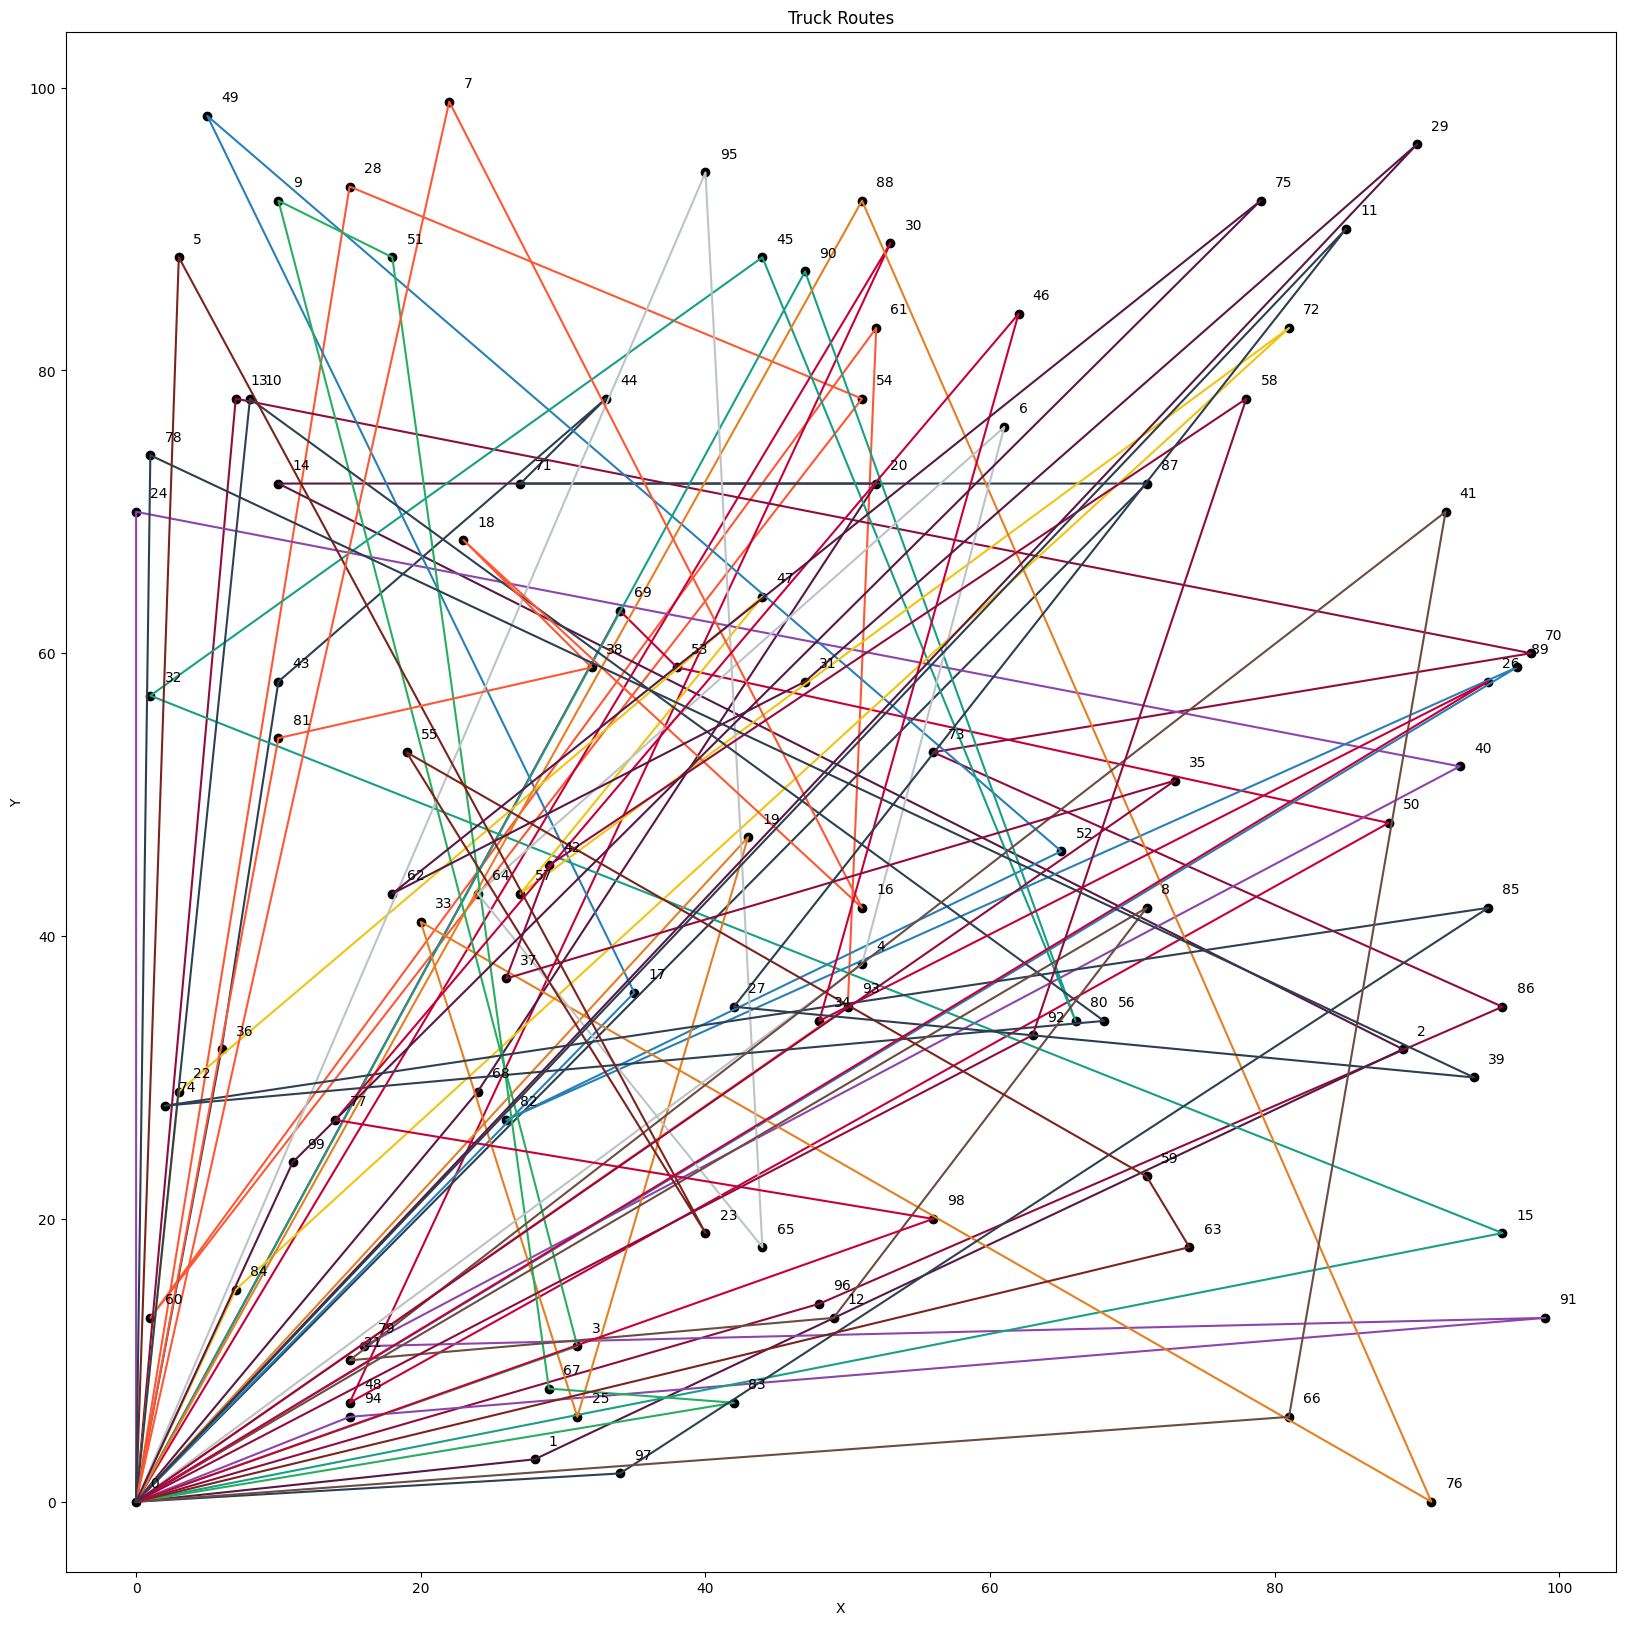



-TOTAL DISTANCE COVERED BY THIS POPULATION = 6147.3347498367275


In [184]:
iterations = int(input("Number of Iterations: "))
print('\n')
cog = 1.5
soc = 2.5
v_max = 1

bestFit, l = PSO(trucks, num_trucks, iterations, capacity, num_customers, v_max, cog, soc)
plot_optimal(df, l)
print('\n')
print(f"-TOTAL DISTANCE COVERED BY THIS POPULATION = {bestFit}")